In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from lightgbm import LGBMClassifier

# <a id='data'>2. Studying the data</a>
<a href='#toc'><span class="label label-info">Go back to Table of Contents</span></a>

In this section, I'll fetch the train and test data and study their distributions. Interestingly, this competition has both tabular as well as image data. So, I will be extracting the features from Images and then combine it with the tabular data and then make the predictions.

In [2]:
df_train = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
df_test = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [3]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


None

In [4]:
print('No of patients in train set(A): {}'.format(len(df_train.patient_id.unique().tolist())))
print('No of patients in test set(B): {}'.format(len(df_test.patient_id.unique().tolist())))
print('No of patients that are in train set but not test set(A-B): {}'.format(len(set(df_train.patient_id.unique()) - set(df_test.patient_id.unique()))))
print('No of patients that are in test set but not train set(B-A): {}'.format(len(set(df_test.patient_id.unique()) - set(df_train.patient_id.unique()))))
print('*'*64)
print('No of images in train set(C): {}'.format(len(df_train.image_name.unique().tolist())))
print('No of images in test set(D): {}'.format(len(df_test.image_name.unique().tolist())))
print('No of images that are in train set but not test set(C-D): {}'.format(len(set(df_train.image_name.unique()) - set(df_test.image_name.unique()))))
print('No of images that are in test set but not train set(D-C): {}'.format(len(set(df_test.image_name.unique()) - set(df_train.image_name.unique()))))

No of patients in train set(A): 2056
No of patients in test set(B): 690
No of patients that are in train set but not test set(A-B): 2056
No of patients that are in test set but not train set(B-A): 690
****************************************************************
No of images in train set(C): 33126
No of images in test set(D): 10982
No of images that are in train set but not test set(C-D): 33126
No of images that are in test set but not train set(D-C): 10982


**Clearly there are no common patients and images between the train and test data. So, while training we should drop both these columns as these are not adding any value.**

Now, lets study the distribution of data across train and test set.

In [5]:
PAPER_BGCOLOR = '#FFFFFF'
PLOT_BGCOLOR = '#FFFFFF'

In [6]:
group_age_train = df_train.groupby('age_approx')['patient_id','image_name'].nunique()
group_age_test = df_test.groupby('age_approx')['patient_id','image_name'].nunique()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.02,
                    subplot_titles=['Patients and their age',
                                   'Images available wrt age'])
fig.add_trace(go.Bar(y=group_age_train.index,x=group_age_train['patient_id'],orientation='h',name='Train',
                        legendgroup='Train',marker_color='rgb(119, 221, 119)',marker_line_color='black',
                        marker_line_width=1.5),1,1)
fig.add_trace(go.Bar(y=group_age_test.index,x=group_age_test['patient_id'],orientation='h',name='Test',
                       legendgroup='Test',marker_color='rgb(119, 158, 203)',marker_line_color='black',
                       marker_line_width=1.5),1,1)
fig.add_trace(go.Bar(y=group_age_train.index,x=group_age_train['image_name'],orientation='h',name='Train',
                     legendgroup='Train',marker_color='rgb(119, 221, 119)',marker_line_color='black',showlegend=False,
                    marker_line_width=1.5),1,2)
fig.add_trace(go.Bar(y=group_age_test.index,x=group_age_test['image_name'],orientation='h',name='Test',
                     legendgroup='Test',marker_color='rgb(119, 158, 203)',marker_line_color='black',showlegend=False,
                     marker_line_width=1.5),1,2)
fig.update_yaxes(title_text='Age',row=1,col=1,nticks=20,tickfont=dict(size=10),
                mirror=True,linecolor='black',linewidth=2)
fig.update_yaxes(mirror=True,linecolor='black',linewidth=2)
fig.update_xaxes(title_text='Number of Patients',row=1,col=1,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_xaxes(title_text='Number of Images',row=1,col=2,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_layout(width=700,paper_bgcolor=PAPER_BGCOLOR,plot_bgcolor=PLOT_BGCOLOR, barmode='stack',hovermode='y unified',
                 margin=dict(l=0,r=0,t=0,b=0),legend=dict(title='<b>Dataset</b>',x=0.85,y=0.99))
fig.show()

In [7]:
group_sex_train = df_train.groupby('sex')['patient_id','image_name'].nunique()
group_sex_test = df_test.groupby('sex')['patient_id','image_name'].nunique()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.1,
                    subplot_titles=['Patients and their sex',
                                   'Images available wrt sex'])
fig.add_trace(go.Bar(y=group_sex_train.index,x=group_sex_train['patient_id'],orientation='h',name='Train',
                        legendgroup='Train',marker_color='rgb(119, 221, 119)',marker_line_color='black',
                        marker_line_width=2),1,1)
fig.add_trace(go.Bar(y=group_sex_test.index,x=group_sex_test['patient_id'],orientation='h',name='Test',
                       legendgroup='Test',marker_color='rgb(119, 158, 203)',marker_line_color='black',
                        marker_line_width=2),1,1)
fig.add_trace(go.Bar(y=group_sex_train.index,x=group_sex_train['image_name'],orientation='h',name='Train',
                 legendgroup='Train',marker_color='rgb(119, 221, 119)',showlegend=False,marker_line_color='black',
                        marker_line_width=2),1,2)
fig.add_trace(go.Bar(y=group_sex_test.index,x=group_sex_test['image_name'],orientation='h',name='Test',
                 legendgroup='Test',marker_color='rgb(119, 158, 203)',showlegend=False,marker_line_color='black',
                        marker_line_width=2),1,2)
fig.update_yaxes(title_text='Sex',row=1,col=1,nticks=20,tickfont=dict(size=10),
                mirror=True,linecolor='black',linewidth=2)
fig.update_yaxes(mirror=True,linecolor='black',linewidth=2)
fig.update_xaxes(title_text='Number of Patients',row=1,col=1,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_xaxes(title_text='Number of Images',row=1,col=2,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_layout(width=700,height=300,paper_bgcolor=PAPER_BGCOLOR,plot_bgcolor=PLOT_BGCOLOR, barmode='stack',hovermode='y unified',
                 margin=dict(l=0,r=0,t=70,b=0),legend=dict(title='<b>Dataset</b>',x=0.35,y=1.25,orientation='h'))
fig.show()

In [8]:
group_site_train = df_train.groupby('anatom_site_general_challenge')['patient_id','image_name'].nunique().sort_values(['patient_id','image_name'])
group_site_test = df_test.groupby('anatom_site_general_challenge')['patient_id','image_name'].nunique().sort_values(['patient_id','image_name'])
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.03,
                    subplot_titles=['Imaged site vs Patients',
                                   'Imaged site vs Images'])
fig.add_trace(go.Bar(y=group_site_train.index,x=group_site_train['patient_id'],orientation='h',name='Train',
                        legendgroup='Train',marker_color='rgb(119, 221, 119)',marker_line_color='black',
                        marker_line_width=2),1,1)
fig.add_trace(go.Bar(y=group_site_test.index,x=group_site_test['patient_id'],orientation='h',name='Test',
                       legendgroup='Test',marker_color='rgb(119, 158, 203)',marker_line_color='black',
                        marker_line_width=2),1,1)
fig.add_trace(go.Bar(y=group_site_train.index,x=group_site_train['image_name'],orientation='h',name='Train',
                 legendgroup='Train',marker_color='rgb(119, 221, 119)',showlegend=False,marker_line_color='black',
                        marker_line_width=2),1,2)
fig.add_trace(go.Bar(y=group_site_test.index,x=group_site_test['image_name'],orientation='h',name='Test',
                 legendgroup='Test',marker_color='rgb(119, 158, 203)',showlegend=False,marker_line_color='black',
                        marker_line_width=2),1,2)
fig.update_yaxes(title_text='Location of imaged site',row=1,col=1,nticks=20,tickfont=dict(size=10),
                mirror=True,linecolor='black',linewidth=2)
fig.update_yaxes(mirror=True,linecolor='black',linewidth=2)
fig.update_xaxes(title_text='Number of Patients',row=1,col=1,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_xaxes(title_text='Number of Images',row=1,col=2,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_layout(width=700,height=400,paper_bgcolor=PAPER_BGCOLOR,plot_bgcolor=PLOT_BGCOLOR, barmode='stack',hovermode='y unified',
                 margin=dict(l=0,r=0,t=70,b=0),legend=dict(title='<b>Dataset</b>',x=0.35,y=1.17,orientation='h'))
fig.show()

In [9]:
#Paths to train and test images
train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'

In [10]:
def get_image(img_name,is_train=True,transform=False):
    if is_train:
        path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
    else:
        path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
    if transform:
        img = load_image(path, img_name)
    else:
        path = os.path.join(path,img_name+'.jpg')
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [11]:
def show_data(df,rows,cols,is_train=True,transform=False):
    df.reset_index(inplace=True,drop=True)
    fig = plt.figure(figsize=(6,6),dpi=150)
    i = 1
    for r in range(rows):
        for c in range(cols):
            image_name = df.loc[i-1,'image_name']
            title = 'Patient id: '+df.loc[i-1,'patient_id']+'\n'\
              +'Site: '+str(df.loc[i-1,'anatom_site_general_challenge'])+'\n'\
              +'Sex: '+str(df.loc[i-1,'sex'])+'\n'\
              +'Approximate Age: '+str(int(df.loc[i-1,'age_approx']))
            ax = fig.add_subplot(rows,cols,i)
            img = get_image(image_name,is_train,transform)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title,fontsize=5)
            ax.imshow(img)
            i+=1
    return fig

**Let's take a look at some benign tumours from the train set.**

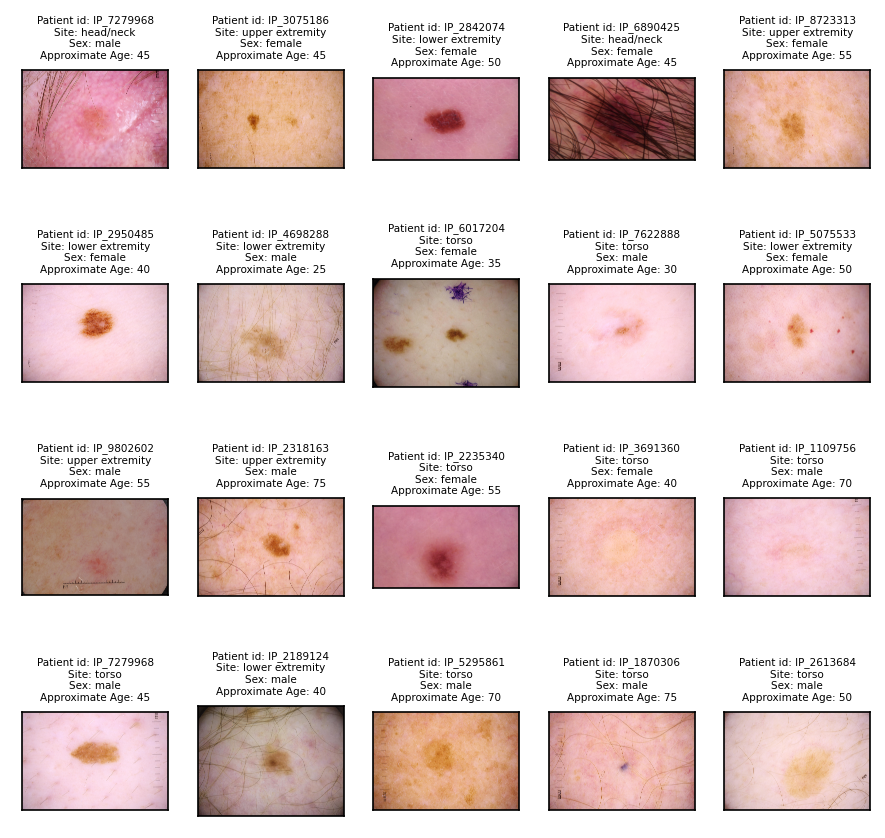

In [12]:
fig = show_data(df_train[df_train['benign_malignant']=='benign'].iloc[:20,:],4,5)
fig.tight_layout()

**Now let's take a look at some malignant tumours from the train set.**

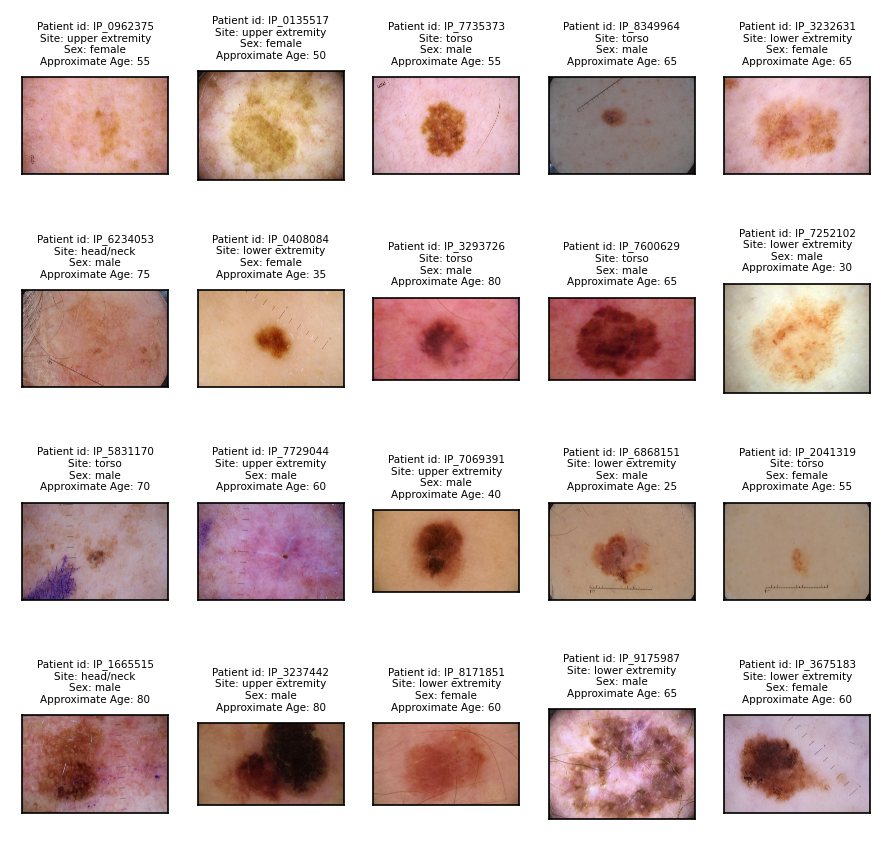

In [13]:
fig = show_data(df_train[df_train['benign_malignant']=='malignant'].iloc[:20,:],4,5)
fig.tight_layout()

**Finally,let's check what we have to predict.**

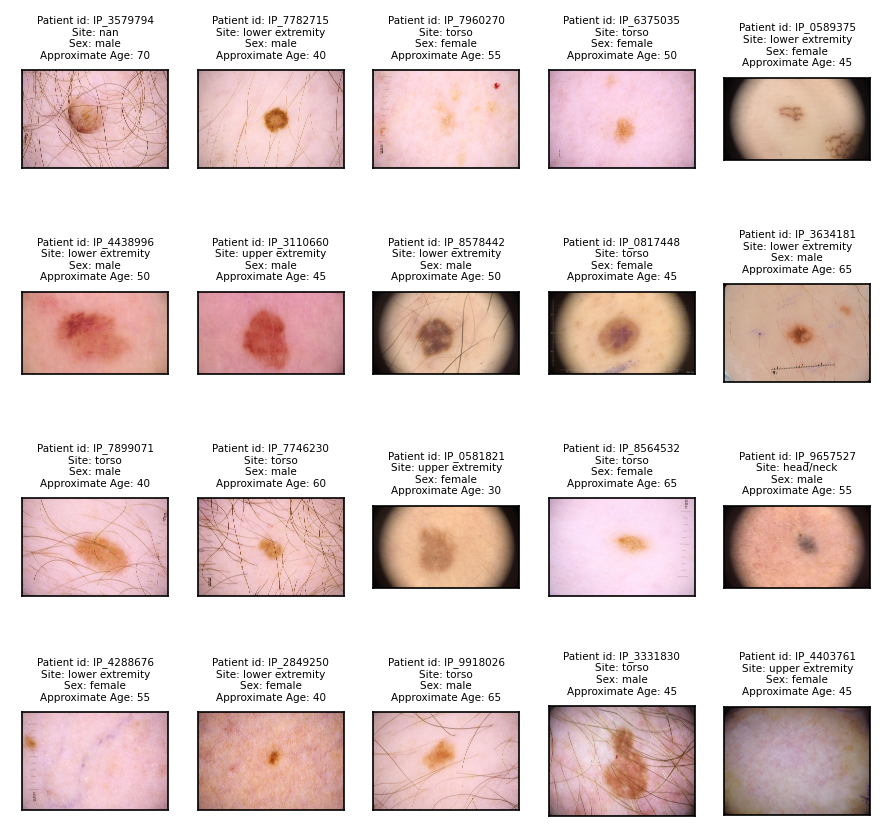

In [14]:
fig = show_data(df_test.iloc[:20,:],4,5,is_train=False)
fig.tight_layout()

# <a id='eda'>3. Exploratory Data Analysis</a>
<a href='#toc'><span class="label label-info">Go back to Table of Contents</span></a>

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Pie_chart_of_incidence_and_malignancy_of_pigmented_skin_lesions.png/1920px-Pie_chart_of_incidence_and_malignancy_of_pigmented_skin_lesions.png' style="width:500px;height:300px;">
Various differential diagnoses of pigmented skin lesions, by relative rates upon biopsy and malignancy potential, including "melanoma" at right.

**Below plots show the analysis of Imaged sites with respect to Sex, Diagnosis and Tumour type.**

In [15]:
fig = make_subplots(rows=1,cols=3,shared_yaxes=True, horizontal_spacing=0.03,
                    subplot_titles=['wrt Sex','wrt Diagnosis','wrt Tumour type'])
group = df_train.groupby(['anatom_site_general_challenge','sex'],as_index=False)['patient_id'].count().dropna()
for sex in group.sex.unique():
    group_n = group[group['sex']==sex].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['anatom_site_general_challenge'],orientation='h',
                            showlegend=False,name=sex,marker_line_color='black',marker_line_width=1.5),1,1)
group = df_train.groupby(['anatom_site_general_challenge','diagnosis'],as_index=False)['patient_id'].count().dropna()
for diag in group.diagnosis.unique():
    group_n = group[group['diagnosis']==diag].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['anatom_site_general_challenge'],orientation='h',
                            showlegend=False,name=diag,marker_line_color='black',marker_line_width=1.5),1,2)
group = df_train.groupby(['anatom_site_general_challenge','benign_malignant'],as_index=False)['patient_id'].count().dropna()
for type in group.benign_malignant.unique():
    group_n = group[group['benign_malignant']==type].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['anatom_site_general_challenge'],orientation='h',
                            showlegend=False,name=type,marker_line_color='black',marker_line_width=1.5),1,3)
fig.update_yaxes(title_text='Imaged site',row=1,col=1,nticks=20,tickfont=dict(size=10))
fig.update_yaxes(mirror=True,linecolor='black',linewidth=2)
fig.update_xaxes(row=1,col=1,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_xaxes(title_text='Number of Patients',row=1,col=2,
                 mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_xaxes(row=1,col=3,mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_layout(width=700,height=400,paper_bgcolor=PAPER_BGCOLOR,plot_bgcolor=PLOT_BGCOLOR, 
                  barmode='stack',hovermode='y unified',title='Imaged site Analysis',
                 margin=dict(l=0,r=0,t=70,b=0))
fig.show()

**Below plots show the analysis of Sex of patients with respect to their Diagnosis and Tumour type.**

In [16]:
fig = make_subplots(rows=1,cols=2,shared_yaxes=True, horizontal_spacing=0.03,
                    subplot_titles=['Sex wrt Diagnosis','Sex wrt Tumour type'])
group = df_train.groupby(['sex','diagnosis'],as_index=False)['patient_id'].count().dropna()
for diag in group.diagnosis.unique():
    group_n = group[group['diagnosis']==diag].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['sex'],orientation='h',
                            showlegend=False,name=diag,marker_line_color='black',marker_line_width=1.5),1,1)
group = df_train.groupby(['sex','benign_malignant'],as_index=False)['patient_id'].count().dropna()
for type in group.benign_malignant.unique():
    group_n = group[group['benign_malignant']==type].sort_values('patient_id')
    fig.append_trace(go.Bar(x=group_n['patient_id'],y=group_n['sex'],orientation='h',
                            showlegend=False,name=type,marker_line_color='black',marker_line_width=1.5),1,2)
fig.update_yaxes(title_text='Sex',row=1,col=1)
fig.update_xaxes(title_text='Number of patients',row=1,col=1,
                 mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_xaxes(title_text='Number of patients',row=1,col=2,
                 mirror=True,linecolor='black',linewidth=2,gridcolor='darkgrey')
fig.update_yaxes(mirror=True,linecolor='black',linewidth=2)
fig.update_layout(width=700,height=300,paper_bgcolor=PAPER_BGCOLOR,plot_bgcolor=PLOT_BGCOLOR, 
                  barmode='stack',hovermode='y unified',title='Sex Analysis',
                 margin=dict(l=0,r=0,t=70,b=0))
fig.show()

In [17]:
del group
del group_age_test
del group_age_train
del group_n
del group_sex_test
del group_sex_train
del group_site_test
del group_site_train
gc.collect();

# <a id='res'>4. Resizing the Images</a>
<a href='#toc'><span class="label label-info">Go back to Table of Contents</span></a>

In this section I'll be defining the function to resize the images so that it becomes easier to extract features from them as we have a common ground. Also, I'll be plotting some random resized images from the train set and test set.

**The Image size that I have chosen is 256X256.**

In [18]:
#Size to resize(256,256,3)
img_size = 256

#Paths to train and test images
train_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_img_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'

def resize_image(img):
    old_size = img.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1],new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0,0,0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return new_img

def load_image(path, img_id):
    path = os.path.join(path,img_id+'.jpg')
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img = resize_image(img)
    new_img = preprocess_input(new_img)
    return new_img

<h3>Here's a look at some of the resized images of Benign Tumours.</h3>

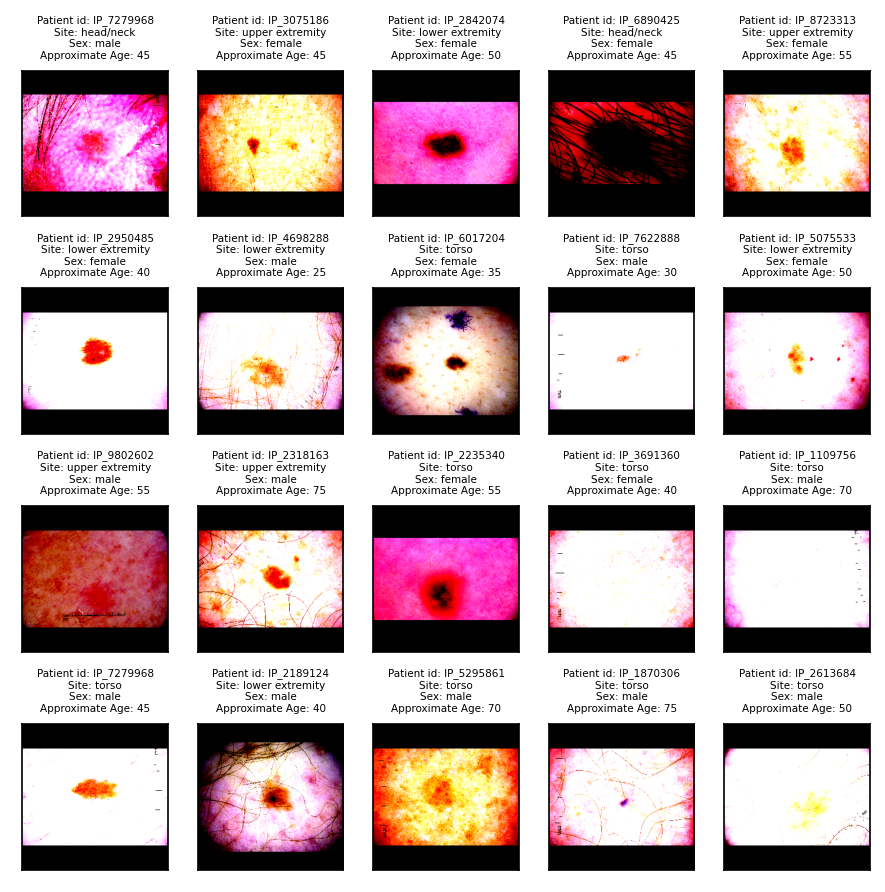

In [19]:
fig = show_data(df_train[df_train['benign_malignant']=='benign'].iloc[:20,:],4,5,transform=True)
fig.tight_layout()

<h3>Also, lets take a look at some of the resized images of Malignant Tumours.</h3>

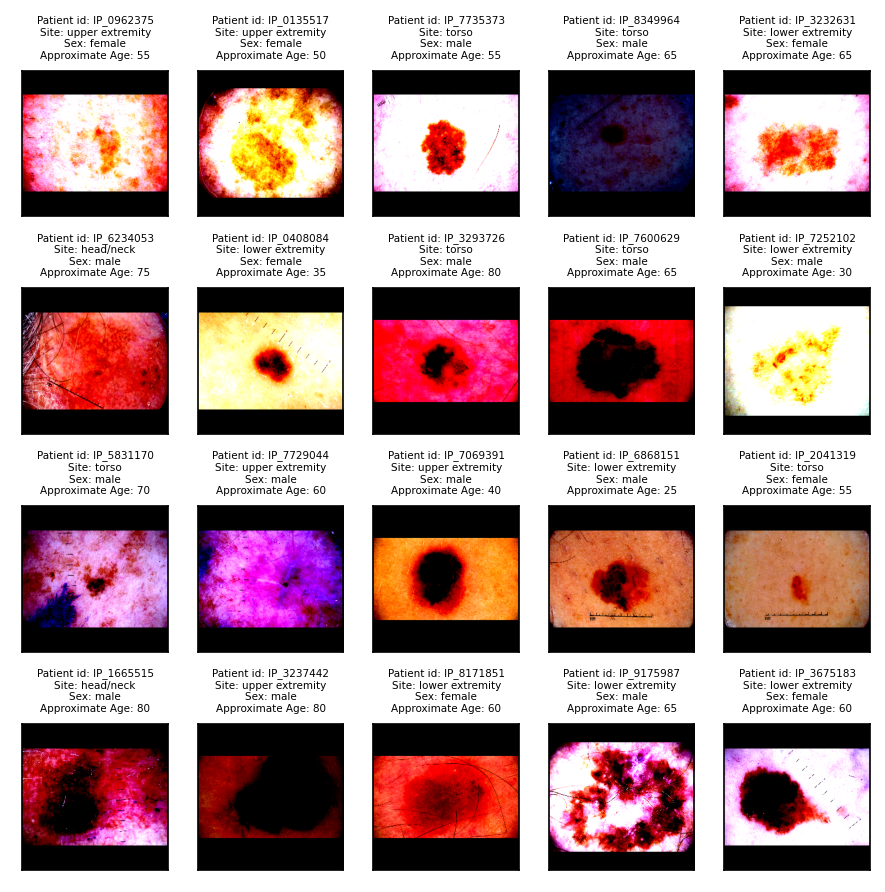

In [20]:
fig = show_data(df_train[df_train['benign_malignant']=='malignant'].iloc[:20,:],4,5,transform=True)
fig.tight_layout()

<h3>Finally, lets also take a look at some images from the test set.</h3>

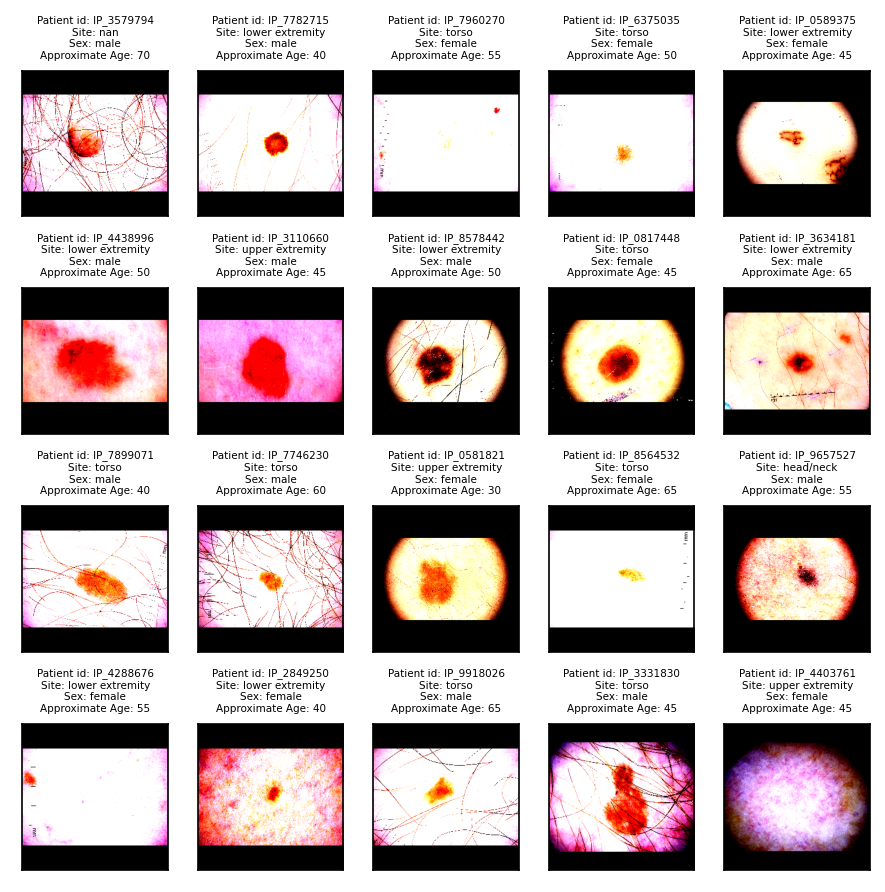

In [21]:
fig = show_data(df_test.iloc[:20,:],4,5,is_train=False,transform=True)
fig.tight_layout()

Clearly, Resizing the images has lead to deteoration of their quality but still features seems to be intact. I could also train resize them 512X512 to extract more features.

# <a id='ext'>5. Extract features from Images</a>
<a href='#toc'><span class="label label-info">Go back to Table of Contents</span></a>

<div class="alert alert-info" role="alert">
 This entire process of extraction of features from Images using DenseNet121 takes more than 2 hours. So, to save on time I have created a public dataset: https://www.kaggle.com/anshuls235/melanomaextractedfeatures. This conatins all the extracted features and can be used by anyone. I'm also using the same. Also, as a result I have commented the code in this section, but can be used by anyone for reference to extract any number of features as per their convenience.
</div>

Here, I'll be extracting Image features using a pretrained Neural network. Later, using these features and the tabular data I'll train a LGBM classifier and make the predictions. The pretrained NN used here is a DenseNet121. Per image I'll be extracting 256 features for both the train and test set.
<img src='https://imgur.com/wWHWbQt.jpg' style="width:800px;height:200px;">
**DenseNet Architecture**
<img src='https://imgur.com/oiTdqJL.jpg' style="width:500px;height:300px;">
Normally DenseNet121 would output 1024 features after GlobalAveragePooling. To further narrow it down, I again pool 4 features each.

In [22]:
# img_size = 256
# batch_size = 16 #16 images per batch

# train_img_ids = df_train.image_name.values
# n_batches = len(train_img_ids)//batch_size + 1

# #Model to extract image features
# inp = Input((256,256,3))
# backbone = DenseNet121(input_tensor=inp, include_top=False)
# x = backbone.output
# x = GlobalAveragePooling2D()(x)
# x = Lambda(lambda x: K.expand_dims(x,axis=-1))(x)
# x = AveragePooling1D(4)(x)
# out = Lambda(lambda x: x[:,:,0])(x)

# m = Model(inp,out)

In [23]:
# features = {}
# for b in tqdm_notebook(range(n_batches)):
#     start = b*batch_size
#     end = (b+1)*batch_size
#     batch_ids = train_img_ids[start:end]
#     batch_images = np.zeros((len(batch_ids),img_size,img_size,3))
#     for i,img_id in enumerate(batch_ids):
#         try:
#             batch_images[i] = load_image(train_img_path,img_id)
#         except:
#             pass
#     batch_preds = m.predict(batch_images)
#     for i,img_id in enumerate(batch_ids):
#         features[img_id] = batch_preds[i]

In [24]:
# train_feats = pd.DataFrame.from_dict(features, orient='index')
# #Save for future reference 
# train_feats.to_csv('train_img_features.csv')
# train_feats.head()

In [25]:
# test_img_ids = df_test.image_name.values
# n_batches = len(test_img_ids)//batch_size + 1

In [26]:
# features = {}
# for b in tqdm_notebook(range(n_batches)):
#     start = b*batch_size
#     end = (b+1)*batch_size
#     batch_ids = test_img_ids[start:end]
#     batch_images = np.zeros((len(batch_ids),img_size,img_size,3))
#     for i,img_id in enumerate(batch_ids):
#         try:
#             batch_images[i] = load_image(test_img_path,img_id)
#         except:
#             pass
#     batch_preds = m.predict(batch_images)
#     for i,img_id in enumerate(batch_ids):
#         features[img_id] = batch_preds[i]

In [27]:
# test_feats = pd.DataFrame.from_dict(features, orient='index')
# test_feats.to_csv('test_img_features.csv')
# test_feats.head()

# <a id='sub'>6. Train the model and predict the results</a>
<a href='#toc'><span class="label label-info">Go back to Table of Contents</span></a>

In this final section, I'll be combining the extracted image features and tabular data available into a single dataframe. I'll be using LGBM Classifier to classify the test data into benign/malignant.

In [28]:
train_feats = pd.read_csv('/kaggle/input/siimisic-extracted-features-from-256x256-image/train_img_features (1).csv')
test_feats = pd.read_csv('/kaggle/input/siimisic-extracted-features-from-256x256-image/test_img_features (1).csv')
train_feats.set_index(train_feats.columns[0],inplace=True)
test_feats.set_index(test_feats.columns[0],inplace=True)

In [29]:
#Combine the image and tabular data
df_train_full = pd.merge(df_train, train_feats, how='inner', left_on='image_name', right_index=True)
df_test_full = pd.merge(df_test, test_feats, how='inner', left_on='image_name', right_index=True)

#Drop the unwanted columns
train = df_train_full.drop(['image_name','patient_id','diagnosis','benign_malignant'],axis=1)
test = df_test_full.drop(['image_name','patient_id'],axis=1)

#Label Encode categorical features
train.sex.fillna('NaN',inplace=True)
test.sex.fillna('NaN',inplace=True)
train.anatom_site_general_challenge.fillna('NaN',inplace=True)
test.anatom_site_general_challenge.fillna('NaN',inplace=True)
le_sex = LabelEncoder()
le_site = LabelEncoder()
train.sex = le_sex.fit_transform(train.sex)
test.sex = le_sex.transform(test.sex)
train.anatom_site_general_challenge = le_site.fit_transform(train.anatom_site_general_challenge)
test.anatom_site_general_challenge = le_site.transform(test.anatom_site_general_challenge)

Since, the data is imbalanced meaning there are a lot of records for benign tumours while very less records for malign tumour. So, I'll be using a Stratified K-fold for validation.

In [30]:
folds = StratifiedKFold(n_splits= 10, shuffle=True)
oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
features = [f for f in train.columns if f != 'target']
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[features], train['target'])):
    train_X, train_y = train[features].iloc[train_idx], train['target'].iloc[train_idx]
    valid_X, valid_y = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
    clf = LGBMClassifier(
        #device='gpu',
        n_estimators=1000,
        learning_rate=0.001,
        max_depth=8,
        colsample_bytree=0.5,
        num_leaves=50,
        random_state=0
    )
    print('*****Fold: {}*****'.format(n_fold))
    clf.fit(train_X, train_y, eval_set=[(train_X, train_y), (valid_X, valid_y)], 
            eval_metric= 'auc', verbose= 20, categorical_feature=[0,2],early_stopping_rounds= 20)

    oof_preds[valid_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

*****Fold: 0*****
Training until validation scores don't improve for 20 rounds
[20]	training's auc: 0.934761	training's binary_logloss: 0.0858709	valid_1's auc: 0.841263	valid_1's binary_logloss: 0.087218
[40]	training's auc: 0.940725	training's binary_logloss: 0.0833662	valid_1's auc: 0.844634	valid_1's binary_logloss: 0.0864164
[60]	training's auc: 0.943599	training's binary_logloss: 0.0811594	valid_1's auc: 0.848723	valid_1's binary_logloss: 0.0856651
[80]	training's auc: 0.946705	training's binary_logloss: 0.0791815	valid_1's auc: 0.852564	valid_1's binary_logloss: 0.0850689
[100]	training's auc: 0.949183	training's binary_logloss: 0.0773632	valid_1's auc: 0.855909	valid_1's binary_logloss: 0.0845963
[120]	training's auc: 0.951424	training's binary_logloss: 0.0756792	valid_1's auc: 0.855453	valid_1's binary_logloss: 0.0841156
Early stopping, best iteration is:
[107]	training's auc: 0.950035	training's binary_logloss: 0.0767665	valid_1's auc: 0.856343	valid_1's binary_logloss: 0.084

Here's a graph showcasing the feature importances averaged over folds.

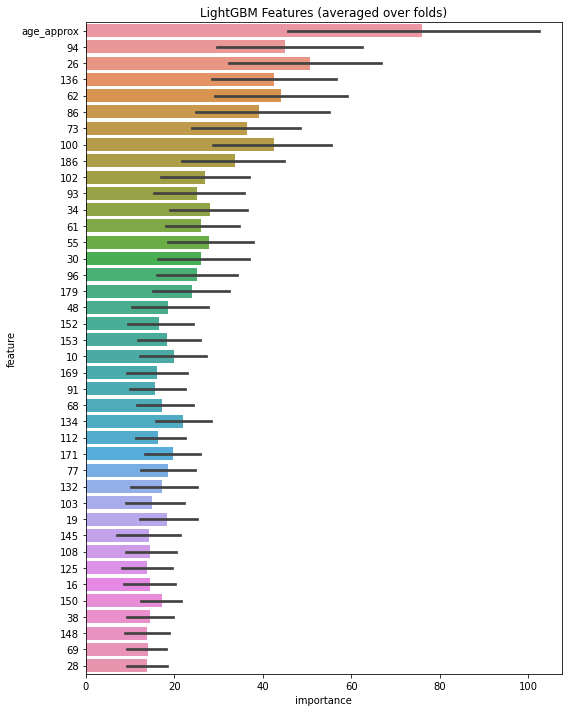

In [31]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    plt.savefig('feature_importance.jpg')
    
display_importances(feature_importance_df)

Make the submission!

In [32]:
submission = pd.DataFrame({
    "image_name": df_test.image_name, 
    "target": sub_preds
})
submission.to_csv('submission.csv', index=False)